To run this file upload the data.tsv file into a folder "data"(i.e data/data.tsv) and run the code in order.

In [1]:
import sys
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import spacy
from tabulate import tabulate

In [2]:
# TextDataset is Described in Section 3.3 of Assignment 2
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "data"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X 
        self.Y = torch.tensor(Y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [3]:
# my_collate_function prepares batches
# it also pads each batch with zeroes.

def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function 
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device), 
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [4]:
def createDatasets(df):
    train, test = train_test_split(df[['text', 'label']], test_size=0.2, random_state=0, stratify=df[['label']])

    trainFinal, val = train_test_split(train, test_size=0.2, random_state=0, stratify=train['label'])

    #writing to train, val and test tsv
    trainFinal.to_csv('data/train.tsv', sep="\t", index=False)
    test.to_csv('data/test.tsv', sep="\t", index=False)
    val.to_csv('data/validation.tsv', sep="\t", index=False)

    #creating overfit dataset and writing to tsv
    s0 = trainFinal.label[df.label.eq(0)].sample(25).index
    s1 = trainFinal.label[df.label.eq(1)].sample(25).index 

    overfit = trainFinal.loc[s0.union(s1)]
    overfit.to_csv('data/overfit.tsv', sep="\t", index=False)


In [5]:
def print_closest_cosine_words(glove, vec, n=5):
    cosine_words = []
    dists = torch.cosine_similarity(vec, glove.vectors) 
    lst = sorted(enumerate(dists.detach().numpy()), key=lambda x: x[1], reverse=True)
    for idx, difference in lst[1:n+1]:   
        cosine_words.append(glove.itos[idx] + " - %5.2f" % difference)
    return cosine_words

In [6]:
def main(batch_size):
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    df = pd.read_csv("data/data.tsv", sep='\t')
    createDatasets(df)
    glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100

    train_dataset = TextDataset(glove, "train")
    val_dataset = TextDataset(glove, "validation")
    test_dataset = TextDataset(glove, "test")
    overfit_dataset = TextDataset(glove, "overfit")
        
    # 3.3.3
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=lambda batch: my_collate_function(batch, device))
    
    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=lambda batch: my_collate_function(batch, device))
    
    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))
    
    overfit_dataloader = torch.utils.data.DataLoader(
        dataset=overfit_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))
    
    predictionCNNModel = trainCNNModel(train_dataloader, validation_dataloader,test_dataloader, overfit_dataloader, glove, 100, batch_size, 10, 0.001)
    torch.save(predictionCNNModel, 'model_{}.pt'.format("CNN"))
    cvWeights = predictionCNNModel.conv2.weight
    print(cvWeights.shape)
    weight = torch.mean(torch.mean(cvWeights, 1), 1)[0]
    print(weight.shape)
    mydata = [
        ["CV2 layer weight", [i for i in print_closest_cosine_words(glove, weight, n=5)]]
    ]
    # create header
    head = ["word", "Cosine Similarity"]

    # display table
    print(tabulate(mydata, headers=head, tablefmt="grid"))

In [7]:
class CNN(nn.Module):
    def __init__(self, embedding_dim, vocab,n1=50,n2=50,k1=2,k2=4):
        super(CNN, self).__init__()
        self.embed_layer = nn.Embedding.from_pretrained(vocab.vectors,freeze=False)
        self.conv1 = nn.Conv2d(1, n1, (k1, 100), 1, bias=False)
        self.conv2 = nn.Conv2d(1, n2, (k2, 100), 1, bias=False)
        self.activation = nn.ReLU()
        self.fc1 = nn.Linear(n2*2, 1)

    def forward(self, x):
        length = len(x)
        embed_result = self.embed_layer(x)
        #print(embed_result.shape)
        embed_result = embed_result.permute(1, 0, 2)
        #print(embed_result.shape)
        embed_result = embed_result.unsqueeze(1)
        #print(embed_result.shape)

        cnn1 = self.conv1(embed_result)
        #print(cnn1.shape)
        cnn2 = self.conv2(embed_result)
        #print(cnn2.shape)

        cnn1_activation = self.activation(cnn1)
        #print(cnn1_activation.shape)
        cnn1_activation = cnn1_activation.squeeze()
        #print(cnn1_activation.shape)
        cnn2_activation = self.activation(cnn2)
        #print(cnn2_activation.shape)
        cnn2_activation = cnn2_activation.squeeze()
        #print(cnn2_activation.shape)

        cnn1_maxpool = nn.functional.max_pool1d(cnn1_activation, int(length - 1))
        #print(cnn1_maxpool.shape)
        cnn2_maxpool = nn.functional.max_pool1d(cnn2_activation, int(length - 3))
        #print(cnn2_maxpool.shape)

        cnn1_result = cnn1_maxpool.squeeze()
        #print(cnn1_result.shape)
        cnn2_result = cnn2_maxpool.squeeze()
        #print(cnn2_result.shape)

        concat_result = torch.cat((cnn1_result, cnn2_result), 1)
        #print(concat_result.shape)
        prediction = self.fc1(concat_result)
        #print(prediction.shape)
        return prediction

In [8]:
def evaluate(model, dataLoader, criterion, batch_size):
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        total_corr = 0
        p =0
        for index,context in iter(dataLoader):
            index = index.type(torch.long)
            context = context.type(torch.float)
            logits = model(index)
            loss = criterion(logits.squeeze(1), context)
            test_loss += float(loss)/batch_size
            p += 1
            corr = (logits > 0.5).squeeze().long() == context
            total_corr += int(corr.sum())
    return test_loss, total_corr, p

In [9]:
from tqdm import tqdm
def trainCNNModel(train_dataloader, validation_dataloader, test_dataloader, overfit_dataloader, vocab, embedding_size, batch_size, epochs, lr):
    model = CNN(100, vocab)
    criterion = torch.nn.BCEWithLogitsLoss()
    opt_func = torch.optim.Adam
    optimizer = opt_func(model.parameters(), lr)       

    train_loss_list = []
    val_loss_list = []
    test_loss_list = []
    overfit_loss_list = []
    train_acc = []
    val_acc = []
    test_acc = []
    overfit_acc = []

    #train model using train set
    iters = np.arange(0,epochs)
    for epoch in range(epochs):
        train_loss= 0.0
        total_corr = 0
        model.train()
        n = 0
        for index,context in tqdm(iter(train_dataloader)): 
            index = index.type(torch.long)
            context = context.type(torch.float)
            logits = model(index)
            loss = criterion(logits.squeeze(1), context)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss = train_loss + float(loss)/batch_size
            n += 1
            corr = (logits > 0.5).squeeze().long() == context
            total_corr += int(corr.sum())
        train_loss_list.append(train_loss/n)
        train_acc.append(float(total_corr) / len(train_dataloader.dataset))

        #evaluate validation set
        val_loss, total_corr, p = evaluate(model, validation_dataloader, criterion, batch_size)
        val_loss_list.append(val_loss/p) 
        val_acc.append(float(total_corr) / len(validation_dataloader.dataset))

        #evaluate test set
        test_loss, total_corr, p = evaluate(model, test_dataloader, criterion, batch_size)
        test_loss_list.append(test_loss/p) 
        test_acc.append(float(total_corr) / len(test_dataloader.dataset))

        #evaluate overfit set
        overfit_loss, total_corr, p = evaluate(model, overfit_dataloader, criterion, batch_size)
        overfit_loss_list.append(overfit_loss/p) 
        overfit_acc.append(float(total_corr) / len(overfit_dataloader.dataset))

    print("Validation Accuracy: " + str(val_acc[-1]), "Validation Loss: " + str(val_loss_list[-1]))

    print("Test Accuracy: " + str(test_acc[-1]), "Test Loss: " + str(test_loss_list[-1]))
    print("Overfit Accuracy: " + str(overfit_acc[-1]), "Overfit Loss: " + str(overfit_loss_list[-1]))

    #plot loss curve
    plt.title("Loss Curve")
    plt.plot(iters, train_loss_list, label="Train")
    plt.plot(iters, val_loss_list, label="Validation")
    plt.plot(iters, overfit_loss_list, label="Overfit")
    plt.plot(iters, test_loss_list, label="Test")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    #plot Accuracy curve
    plt.title("Accuracy Curve")
    plt.plot(iters, train_acc, label="Train accuracy")
    plt.plot(iters, val_acc, label="Validation accuracy")
    plt.plot(iters, overfit_acc, label="Overfit accuracy")
    plt.plot(iters, test_acc, label="Test accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
    return model

.vector_cache/glove.6B.zip: 862MB [02:39, 5.39MB/s]                           
100%|██████████| 640/640 [05:49<00:00,  1.83it/s]


Validation Accuracy: 0.921875 Validation Loss: 0.03124573850447831
Test Accuracy: 0.921 Test Loss: 0.032401702633450206
Overfit Accuracy: 1.0 Overfit Loss: 1.621095812879503e-05


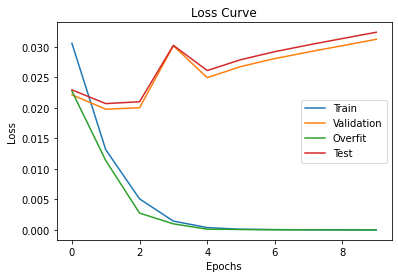

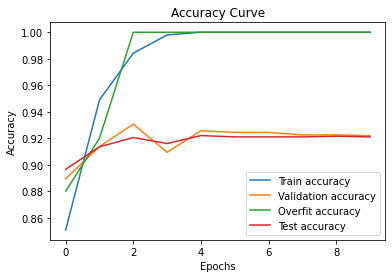

torch.Size([50, 1, 4, 100])
torch.Size([100])
+------------------+--------------------------------------------------------------------------------------------------------+
| word             | Cosine Similarity                                                                                      |
+==================+========================================================================================================+
| CV2 layer weight | ['recruited -  0.45', 'flees -  0.44', 'kidnapped -  0.44', 'imprisoned -  0.44', 'discovers -  0.44'] |
+------------------+--------------------------------------------------------------------------------------------------------+


In [10]:
if __name__ == '__main__':
    main(10)